# Speech to Text Prediction

Now that we know the basics of audio signals - graphing them and manipulating them - we are ready to move to the next step in the voice assistant pipeline, which is converting user audio signals into text.

<img src="https://miro.medium.com/max/1024/1*hvhbk3n9SAcI3yS_D1IuXQ.png" width=400>

This task is difficult because training a model to accurately transcribe an audio signal into textual data faces challenges of background noise, varying pitches and accents, and more which cause variation and inconsistencies in training data.

In [1]:
#@title Run to download packages and data
import os
import librosa
import IPython.display as ipd
from IPython.display import Audio
import matplotlib.pyplot as plt
import numpy as np
from scipy.io import wavfile
from sklearn.preprocessing import LabelEncoder
from keras.utils import np_utils
from sklearn.model_selection import train_test_split
import tensorflow as tf
import scipy.signal as signal
!pip install torchaudio
import torchaudio.functional as funct

!wget 'https://storage.googleapis.com/inspirit-ai-data-bucket-1/Data/Deep%20Dives/Advanced%20Topics%20in%20AI/Sessions%206%20-%2010%20(Projects)/Project%20-%20Audio%20Processing/audio_data.pickle'
!wget 'https://storage.googleapis.com/inspirit-ai-data-bucket-1/Data/Deep%20Dives/Advanced%20Topics%20in%20AI/Sessions%206%20-%2010%20(Projects)/Project%20-%20Audio%20Processing/audio_labels.pickle'

# Load in all data as samples
import pickle
data = []
labels = []
audio_labels_file = 'audio_labels.pickle'
audio_data_file = 'audio_data.pickle'
with open(audio_data_file, 'rb') as f:
   data = pickle.load(f)
with open(audio_labels_file, 'rb') as f:
   labels = pickle.load(f)

     |████████████████████████████████| 1.9MB 33.9MB/s 
--2021-07-11 02:25:54--  https://storage.googleapis.com/inspirit-ai-data-bucket-1/Data/Deep%20Dives/Advanced%20Topics%20in%20AI/Sessions%206%20-%2010%20(Projects)/Project%20-%20Audio%20Processing/audio_data.pickle
Resolving storage.googleapis.com (storage.googleapis.com)... 142.250.81.208, 142.251.33.208, 172.217.13.80, ...
Connecting to storage.googleapis.com (storage.googleapis.com)|142.250.81.208|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 128000163 (122M) [application/octet-stream]
Saving to: ‘audio_data.pickle’

audio_data.pickle   100%[===================>] 122.07M   265MB/s    in 0.5s    

2021-07-11 02:25:55 (265 MB/s) - ‘audio_data.pickle’ saved [128000163/128000163]

--2021-07-11 02:25:55--  https://storage.googleapis.com/inspirit-ai-data-bucket-1/Data/Deep%20Dives/Advanced%20Topics%20in%20AI/Sessions%206%20-%2010%20(Projects)/Project%20-%20Audio%20Processing/audio_labels.pickle
Resolving st

**Speech Recognition**

What we are performing in this notebook goes by many names: automatic speech recognition (ASR), computer speech recognition, or speech to text (STT).

Some systems are fine-tuned to recognize a specific person's speech, while most are 'speaker independent' systems - which is what we are doing in our model.

The field of speech recognition has come a long way - from a single-speaker digit recognition system built in 1952, to sophisticated speaker-independent systems that can fairly accurately recognize any audio signal today.



##About the dataset
We are using [TensorFlow's](https://www.tensorflow.org/datasets/catalog/speech_commands) Speech Commands Dataset. The dataset contains thousands of recordings of roughly 1 second utterances from various people, of twenty distinct words and the digits 0 through 9. We will use sample wav files from all 30 classes, but only a subset of them since it takes time to sample from each audio signal to get the format needed for our models.

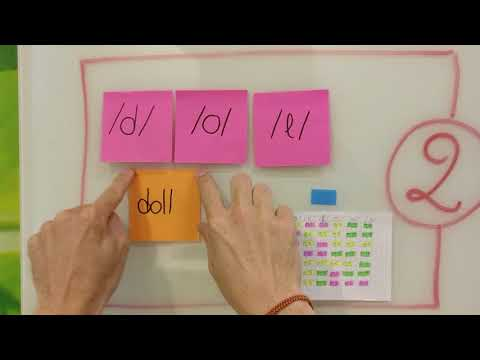

In [2]:
#@title Run for Video
from IPython.display import YouTubeVideo
YouTubeVideo('U0XtE4_QLXI')

### Exercise 1

Check the sizes of data and labels. (Hint: what is the type of each?).

In [3]:
### YOUR CODE HERE ###
print(data.shape)


(2000, 8000)


### Exercise 2

Use numpy's [unique](https://numpy.org/doc/stable/reference/generated/numpy.unique.html) function to observe and count the unique labels present in our dataset.

In [4]:
# The unique labels will be the words we are predicting from audio.
unique_labels = np.unique(np.array(labels.copy()))### YOUR CODE HERE ###        

num_unique_labels = len(unique_labels)### YOUR CODE HERE #### 
print("\n There are {} unique labels.".format(num_unique_labels))


 There are 5 unique labels.


### Exercise 3

In [5]:
# Convert labels into one-hot encoding vectors for multi-class classification.
le = LabelEncoder()
y = le.fit_transform(labels)
y = np_utils.to_categorical(y, num_classes= num_unique_labels)###YOUR CODE HERE ###)
print(y)

[[1. 0. 0. 0. 0.]
 [1. 0. 0. 0. 0.]
 [1. 0. 0. 0. 0.]
 ...
 [0. 1. 0. 0. 0.]
 [0. 1. 0. 0. 0.]
 [0. 1. 0. 0. 0.]]


**Discuss**: Why do we use one hot encoding vectors as seen above for our labels, as opposed to keeping the labels in text form (i.e. "bed", "bird", ...) or even as singular values (i.e. 1, 2, ...)?

### Example Audio Signal

Let's plot the amplitude against time and listen to the corresponding audio, for a single example from our dataset.

You can experiment with changing the index (`idx`) in our `data` list of samples from wav files you would like to plot and listen to.

#### Exercise 4

Mounted at /content/drive


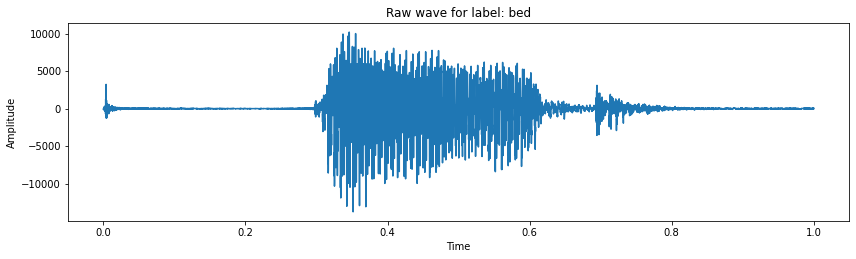

In [6]:
# Plot amplitude vs time graph.
from google.colab import drive
drive.mount('/content/drive')

idx = 100 # try changing this
# TODO: get the samples and label for the given index audio clip
samples = data[idx]### YOUR CODE HERE ###
label = labels[idx]### YOUR CODE HERE ###

fig = plt.figure(figsize=(14, 8))
ax1 = fig.add_subplot(211)
ax1.set_title('Raw wave for label: ' + label) # includes groundtruth label
ax1.set_xlabel('Time')
ax1.set_ylabel('Amplitude')
ax1.plot(np.linspace(0, 8000/len(samples), 8000), samples) # sample_rate is 8000 for all
local_path = "/content/drive/My Drive/Colab Notebooks/Data/"
wav_filename = os.listdir(local_path + label)[idx]
Audio(local_path + label + "/" + wav_filename)

In [7]:
# Listen to the corresponding audio file.
wav_filename = os.listdir(local_path + label)[idx]
Audio(local_path + label + "/" + wav_filename)

Is there anything interesting about the plot or sound of the audio signal you chose?

### Separate into train & test


In [8]:
# Reshape data to have a 2d input (excluding batch size) for model
data = np.array(data).reshape(-1,8000,1)
print(data.shape)

(2000, 8000, 1)


#### Exercise 5

We are splitting our 2000 examples into **80% for training** and 20% for testing. 


Use the `train_test_split` sklearn [function](https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.train_test_split.html) below.

In [9]:
# TODO: use train_test_split with the proper arguments and return values.
### YOUR CODE HERE ###
x_train, x_test, y_train, y_test = train_test_split(data, y, test_size = 0.33, shuffle=True)


**Discuss:** What does the `stratify` parameter mean and do for `train_test_split`? (Hint: google around to find out).

Why might this be helpful to include?



##Create a Classification Model

Let's work our way up to defining our own multi-class classification model from scratch with [Keras](https://keras.io/api/models/model/).



### Convolution Layers


You might be familiar with the concept of convolution from computer vision. In that application, images are defined as 2d grids with rows and columns of pixel intensity values. Since they are two-dimensional, we would use a 2d convolution kernel to scan over the image and perform element-wise multiplication and then sum the values together.

<img src="https://embarc.org/embarc_mli/doc/build/html/_images/image104.jpg" width=200>

In this case, we are using one-dimensional audio signals represented by a list of samples of amplitude values along a timescale. This is why for this application, when we use a convolution neural network we want to use a 1d kernel. In Keras, this is done with a `Conv1d` layer. 

<img src="https://upload.wikimedia.org/wikipedia/commons/2/21/4-bit-linear-PCM.svg" width=200>

#### Exercise 6

Create a sample [Conv1d layer](https://keras.io/api/layers/convolution_layers/convolution1d/) with 4 filters, a kernel size (length of the convolution window) of 12, and ReLU activation function.

In [10]:
from keras.layers import Conv1D

sample_conv_layer = Conv1D(4, 12, activation='relu')### YOUR CODE HERE ###

###MaxPooling Layers

MaxPooling is also a downsampling technique used in convolutional neural networks for computer vision, in which the maximum value in a certain image subregion is kept and all other values are discarded.

<img src="https://qph.fs.quoracdn.net/main-qimg-8afedfb2f82f279781bfefa269bc6a90.webp" width=300>

Why is MaxPooling used?

1. Reduce the spatial size of the data --> fewer parameters and faster computation

2. Prevent overfitting the training data

3. Achieve translational invariance (i.e. recognize same subject even if it's slightly morphed)


We can also make use of MaxPooling in CNNs for audio data, and simply use a one-dimensional layer as opposed to two-dimensional.

<img src="https://peltarion.com/static/1d_global_max_pooling.png" width=200>

#### Exercise 7

Create a sample [MaxPooling1d layer](https://keras.io/api/layers/pooling_layers/max_pooling1d/) with a pooling window of 4 (and a stride equal to the pooling window size).

In [11]:
from keras.layers import MaxPooling1D

sample_pool_layer = MaxPooling1D(4,2)### YOUR CODE HERE ###

### Exercise 8

What is dropout and why do we use it in AI models?

###Our Own Keras Model





#### Exercise 9

Finish implementing the following keras model by adding two or more convolution layers (with MaxPool and/or Dropout, as you see fit). 

Try growing the number of filters & reducing the kernel size for each convolutional layer.


In [12]:
from keras.models import Sequential
from keras.layers import Dense, Dropout, Flatten, Input, Conv1D, MaxPooling1D
from keras.callbacks import EarlyStopping, ModelCheckpoint

model = Sequential()

# First Conv1D layer
model.add(Conv1D(8, 12, activation='relu', input_shape=(8000,1)))
model.add(MaxPooling1D(3))
model.add(Dropout(0.3))

# Second Conv1D layer
model.add(Conv1D(16, 11, activation='relu'))
model.add(MaxPooling1D(3))
model.add(Dropout(0.2))

### YOUR CODE HERE ###
# TO-DO: add 2 more Convolution layers, with MaxPooling & Dropout as needed

model.add(Conv1D(32, 10, activation='relu'))
model.add(MaxPooling1D(3))
model.add(Dropout(0.1))

model.add(Conv1D(64, 9, activation='relu'))
model.add(MaxPooling1D(3))
model.add(Dropout(0.1))
#END CODE

model.add(Flatten())

# Dense Layers
model.add(Dense(256, activation='relu'))
model.add(Dense(128, activation='relu'))
model.add(Dropout(0.2))
model.add(Dense(len(unique_labels), activation='softmax'))

model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_1 (Conv1D)            (None, 7989, 8)           104       
_________________________________________________________________
max_pooling1d_1 (MaxPooling1 (None, 2663, 8)           0         
_________________________________________________________________
dropout (Dropout)            (None, 2663, 8)           0         
_________________________________________________________________
conv1d_2 (Conv1D)            (None, 2653, 16)          1424      
_________________________________________________________________
max_pooling1d_2 (MaxPooling1 (None, 884, 16)           0         
_________________________________________________________________
dropout_1 (Dropout)          (None, 884, 16)           0         
_________________________________________________________________
conv1d_3 (Conv1D)            (None, 875, 32)           5

In [13]:
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

**Discuss**: Why do we use categorical crossentropy loss?

The categorical crossentropy loss function is for when there are two or more label classes (and we have 30). Also, labels are in a one_hot representation. 

If you have integer labels, you would use the sparse categorical crossentropy loss.

#### Early Stopping & Model Checkpoint

In [14]:

es = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=5, min_delta=0.0001) 
mc = ModelCheckpoint('best_model.hdf5', monitor='val_accuracy', verbose=1, save_best_only=True, mode='max')

Determing the number of epochs to train a neural network for is often difficult, and can simply require trial and error. To ease this process, we can make use of a concept called **early stopping**. Early stopping means that you can specify an arbitrary large number of training epochs, but the model will automatically stop training once a performance metric (the `monitor` attribute above) stops improving on the validation (or testing) data. The `mode` attribute specifies if we want to maximize or minimize the metric we pass in for the `monitor` argument.

**Discuss**: What do the other arguments do?


**Model Checkpoint** will save a model or the learned weights at some regular interval, so they can be loaded later to continue the training from the state saved. This is helpful to avoid re-training models from scratch.

#### Exercise 10

Train the model for 100 epochs and a batch size of 32, with the two callback functions defined above (`es` & `mc`).


Recall that we train our models with the `.fit()` function, which returns to us a `history` of the training and validation accuracy and loss values.

In [15]:
### YOUR CODE HERE ###

### YOUR CODE HERE ###
model.fit(x_train, y_train, batch_size=32,epochs=100,callbacks=[es, mc], validation_data=(x_test, y_test))

Epoch 1/100
42/42 [==============================] - 45s 31ms/step - loss: 482.5149 - accuracy: 0.2054 - val_loss: 1.9917 - val_accuracy: 0.1848

Epoch 00001: val_accuracy improved from -inf to 0.18485, saving model to best_model.hdf5
Epoch 2/100
42/42 [==============================] - 0s 9ms/step - loss: 3.8650 - accuracy: 0.2231 - val_loss: 1.6609 - val_accuracy: 0.2333

Epoch 00002: val_accuracy improved from 0.18485 to 0.23333, saving model to best_model.hdf5
Epoch 3/100
42/42 [==============================] - 0s 10ms/step - loss: 2.0690 - accuracy: 0.2392 - val_loss: 1.6339 - val_accuracy: 0.2242

Epoch 00003: val_accuracy did not improve from 0.23333
Epoch 4/100
42/42 [==============================] - 0s 9ms/step - loss: 1.9755 - accuracy: 0.2267 - val_loss: 1.6230 - val_accuracy: 0.2303

Epoch 00004: val_accuracy did not improve from 0.23333
Epoch 5/100
42/42 [==============================] - 0s 9ms/step - loss: 1.7432 - accuracy: 0.2220 - val_loss: 1.6192 - val_accuracy: 0.

#### See Predictions

In [16]:
# Load the best version of our trained model
from keras.models import load_model
best_model = load_model('best_model.hdf5')

##### Exercise 11

We're defining our own `predict` function which will use our best model to get the predicted probabilities of each of the 5 classes, and output the label corresponding to the highest predicted probability.

In [17]:
def predict(audio):
  prob = best_model.predict(audio.reshape(1,8000,1))
  idx = np.argmax(prob[0])

  return unique_labels[idx]### YOUR CODE HERE ###

##### Exercise 12
Let's see how our model does on testing data!

Choose a random audio signal from our testing dataset and output a) the true label, b) the audio clip to listen to, and c) the predicted label.

In [18]:
# Listen to random testing datapoint
rand_idx = np.random.randint(len(x_test))### YOUR CODE HERE ###
samples = x_test[rand_idx].reshape(-1, 8000)
print("Audio:", unique_labels[np.argmax(y_test[rand_idx])])

# TODO: listen to the audio with the ipd.Audio() function
### YOUR CODE HERE ###

Audio: dog


In [19]:
# Predicted label for the above datapoint
print("Prediction:", predict(samples))

Prediction: down


**What do you think of our results?** Can you think of any reasons for not-great results, or ways to improve the model?

### Why is our model so bad?

<img src="https://cdn2.hubspot.net/hubfs/4307349/1_Y6VblMTOVg731-8Uygx5eA.jpeg" width=200>

There are a few reasons why the accuracy is so poor (around 20%) for this baseline model.

First, we might need a much larger quantity of datapoints, as we only have 2000 training examples. However, uploading and sampling more data would require more time, which would take too long for our experimentation here.

Furthermore, we can't really use our 1-D signal of samples directly to train a model.

* Speech signals are **quasi-stationary**. This means that they are locally static over a short period of time, but show differences from one local time frame to another.

* There is **inter- and intra-speaker variability**, i.e. the same word when spoken by different speakers and the same speaker will give different signals.

* There is **speaking rate, pitch, and volume variability** of the signals.

Therefore, we typically do **feature extraction** from a 1-D speech signal before feeding it into an AI model. Common features to use are the spectrogram, or MFCCs. (More on MFCCs in the previous notebook).


## Improve our Model
<!-- 
- bonus: preprocess audio signals like normalize volume, make background quieter, etc -->




### Mel Spectrograms

First, let's create **mel spectrograms** from our data and feed that into our model instead.

As a reminder, spectrograms are generated from computing several spectrums by performing Fast Fourier Transform (FFT) on several windowed segments of an audio signal. A spectrogram is a bunch of FFTs stacked on top of each other. It's a way to represent a signal’s amplitude as it varies over time at different frequencies.

A mel spectrogram is just a spectrogram converted to be on a mel scale, since humans don't perceive frequencies on a linear scale.

#### Preprocess Data



##### Exercise 13

Finish filling in the following to create new training and testing input for our model.

In [20]:
# Create new training and testing data, instead of the direct audio samples from before.
num_train = x_train.shape[0]
num_test = x_test.shape[0] ### YOUR CODE HERE ###

x_train_new = np.zeros((num_train, 128, 16))
x_test_new = np.zeros((num_test, 128, 16)) ### YOUR CODE HERE ###

# use the melspectrogram from librosa
for i in range(num_train):
  x_train_new[i,:,:] = librosa.feature.melspectrogram(y=x_train[i].squeeze(), sr=8000)

# To-Do: Create x_test_new (hint: look at x_train_new above)
### YOUR CODE HERE ###

for i in range(num_test):
  x_test_new[i,:,:] = librosa.feature.melspectrogram(y=x_test[i].squeeze(), sr=8000)

# END CODE

print(x_train_new.shape)
print(x_test_new.shape)

(1340, 128, 16)
(660, 128, 16)


In [21]:
# need to reshape to have a 3d input (ignoring batch size) for model
x_train_new = x_train_new.reshape(-1, 128, 16, 1)
x_test_new = x_test_new.reshape(-1, 128, 16, 1)

print(x_train_new.shape)
print(x_test_new.shape)

(1340, 128, 16, 1)
(660, 128, 16, 1)


#### Create Model

Now when we create our model, we need to change Conv1D to Conv2D layers, and MaxPoolinng1D to MaxPooling2D layers because the input is 3-d from the spectrograms.

##### Exercise 14

Finish filling in the following model.

In [22]:
from keras.layers import Conv2D, MaxPooling2D

model_spect = Sequential() ### YOUR CODE HERE ###


model_spect.add(Conv2D(4, 8, activation='relu', input_shape=(128, 16, 1)))  ### YOUR CODE HERE ###
model_spect.add(MaxPooling2D(2))

model_spect.add(Conv2D(2, 2, activation='relu'))
model_spect.add(Dropout(0.1))

model_spect.add(Conv2D(2, 2, activation='relu'))

model_spect.add(Flatten())

model_spect.add(Dense(256, activation='relu'))
# TODO: add a second Dense layer with half the units 
### YOUR CODE HERE ###
model_spect.add(Dense(128, activation='relu'))
model_spect.add(Dropout(0.1))

# TODO: add the final Dense layer with the correct number of units and activation function
### YOUR CODE HERE ###
model_spect.add(Dense(num_unique_labels, activation='softmax'))

model_spect.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 121, 9, 4)         260       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 60, 4, 4)          0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 59, 3, 2)          34        
_________________________________________________________________
dropout_5 (Dropout)          (None, 59, 3, 2)          0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 58, 2, 2)          18        
_________________________________________________________________
flatten_1 (Flatten)          (None, 232)               0         
_________________________________________________________________
dense_3 (Dense)              (None, 256)              

In [23]:
model_spect.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

##### Exercise 15

Train the model with `.fit()` (like Exercise 10), using the new training and testing data we just created above. (Hint: `x_train_new` and `x_test_new`).

In [24]:
# TODO: ### YOUR CODE HERE ###


model_spect.fit(x_train_new, y_train, batch_size=32,epochs=100,callbacks=[mc], validation_data=(x_test_new, y_test))

Epoch 1/100
42/42 [==============================] - 2s 15ms/step - loss: 1053549139.3488 - accuracy: 0.2823 - val_loss: 216858400.0000 - val_accuracy: 0.3742

Epoch 00001: val_accuracy improved from 0.23333 to 0.37424, saving model to best_model.hdf5
Epoch 2/100
42/42 [==============================] - 0s 5ms/step - loss: 263214818.2326 - accuracy: 0.3674 - val_loss: 125811336.0000 - val_accuracy: 0.3530

Epoch 00002: val_accuracy did not improve from 0.37424
Epoch 3/100
42/42 [==============================] - 0s 5ms/step - loss: 154063625.4884 - accuracy: 0.3730 - val_loss: 91889344.0000 - val_accuracy: 0.3439

Epoch 00003: val_accuracy did not improve from 0.37424
Epoch 4/100
42/42 [==============================] - 0s 4ms/step - loss: 94817959.2558 - accuracy: 0.3708 - val_loss: 71072976.0000 - val_accuracy: 0.3485

Epoch 00004: val_accuracy did not improve from 0.37424
Epoch 5/100
42/42 [==============================] - 0s 5ms/step - loss: 100249175.8140 - accuracy: 0.3754 - val

We can see that the model still does quite poorly, but does slightly better than using the direct audio samples.

### MFCCs

Next, let's try using **MFCCs** as our features that we feed into the same model architecture as the mel spectrogram version.

MFCC stands for Mel Frequency Cepstral Coefficients, and you can learn more about them in the first notebook! Basically, MFCCs features represent phonemes (distinct units of sound).

#### Preprocess Data

In [25]:
# Create new training and testing data, instead of the direct audio samples from before.
x_train3 = np.zeros((num_train, 30, 16))
x_test3 = np.zeros((num_test, 30, 16))

# use the mfcc function from librosa
for i in range(num_train):
  x_train3[i,:,:] = librosa.feature.mfcc(y=x_train[i].squeeze(), sr=8000, n_mfcc=30)

for i in range(num_test):
  x_test3[i,:,:] = librosa.feature.mfcc(y=x_test[i].squeeze(), sr=8000, n_mfcc=30)

print(x_train3.shape)
print(x_test3.shape)

(1340, 30, 16)
(660, 30, 16)


In [26]:
# need to reshape to have a 3d input (ignoring batch size) for model
x_train3 = x_train3.reshape(-1, 30, 16, 1)
x_test3 = x_test3.reshape(-1, 30, 16, 1)

print(x_train3.shape)
print(x_test3.shape)

(1340, 30, 16, 1)
(660, 30, 16, 1)


#### Create Model

In [27]:
# Same model as model_spect, with different input_shape.
model_mfcc = Sequential()

model_mfcc.add(Conv2D(4, 8, activation='relu', input_shape=(30,16,1)))
model_mfcc.add(MaxPooling2D(2))

model_mfcc.add(Conv2D(2, 2, activation='relu'))
model_mfcc.add(Dropout(0.1))
model_mfcc.add(Conv2D(2, 2, activation='relu'))
model_mfcc.add(Dropout(0.1))

model_mfcc.add(Conv2D(2, 2, activation='relu'))

model_mfcc.add(Flatten())

model_mfcc.add(Dense(256, activation='relu'))
model_mfcc.add(Dense(128, activation='relu'))
model_mfcc.add(Dropout(0.1))
model_mfcc.add(Dense(num_unique_labels, activation='softmax'))

model_mfcc.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_3 (Conv2D)            (None, 23, 9, 4)          260       
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 11, 4, 4)          0         
_________________________________________________________________
conv2d_4 (Conv2D)            (None, 10, 3, 2)          34        
_________________________________________________________________
dropout_7 (Dropout)          (None, 10, 3, 2)          0         
_________________________________________________________________
conv2d_5 (Conv2D)            (None, 9, 2, 2)           18        
_________________________________________________________________
dropout_8 (Dropout)          (None, 9, 2, 2)           0         
_________________________________________________________________
conv2d_6 (Conv2D)            (None, 8, 1, 2)          

In [28]:
model_mfcc.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

In [29]:
model_mfcc.fit(x_train3, y_train, epochs=100, callbacks=[es,mc], \
                    batch_size=32, validation_data=(x_test3, y_test))

Epoch 1/100
42/42 [==============================] - 2s 17ms/step - loss: 1.7939 - accuracy: 0.2118 - val_loss: 1.6100 - val_accuracy: 0.2258

Epoch 00001: val_accuracy did not improve from 0.37424
Epoch 2/100
42/42 [==============================] - 0s 5ms/step - loss: 1.6110 - accuracy: 0.2289 - val_loss: 1.6071 - val_accuracy: 0.2030

Epoch 00002: val_accuracy did not improve from 0.37424
Epoch 3/100
42/42 [==============================] - 0s 5ms/step - loss: 1.6097 - accuracy: 0.2568 - val_loss: 1.5959 - val_accuracy: 0.2348

Epoch 00003: val_accuracy did not improve from 0.37424
Epoch 4/100
42/42 [==============================] - 0s 5ms/step - loss: 1.5872 - accuracy: 0.2411 - val_loss: 1.5627 - val_accuracy: 0.2712

Epoch 00004: val_accuracy did not improve from 0.37424
Epoch 5/100
42/42 [==============================] - 0s 5ms/step - loss: 1.5793 - accuracy: 0.2915 - val_loss: 1.5339 - val_accuracy: 0.3015

Epoch 00005: val_accuracy did not improve from 0.37424
Epoch 6/100
42

Great! Looks like MFCCs are a great feature option, and raised our model accuracy substantially.

### Exercise 16

Try changing the architecture of any of the three models we have to see if you can improve their accuracies.

(Hint: experiment with adding more convolution layers, changing convolution argument values, adding or removing dropout layers, changing the optimizer, and so on.)

## Test on user input

In [30]:
#@title Run to enable user input recording

!pip install ffmpeg-python

# from Noé Tits - Numediart google colab notebook
from IPython.display import HTML, Audio
from google.colab.output import eval_js
from base64 import b64decode
import numpy as np
from scipy.io.wavfile import read as wav_read
import io
import ffmpeg

AUDIO_HTML = """
<script>
var my_div = document.createElement("DIV");
var my_p = document.createElement("P");
var my_btn = document.createElement("BUTTON");
var t = document.createTextNode("Press to start recording");

my_btn.appendChild(t);
//my_p.appendChild(my_btn);
my_div.appendChild(my_btn);
document.body.appendChild(my_div);

var base64data = 0;
var reader;
var recorder, gumStream;
var recordButton = my_btn;

var handleSuccess = function(stream) {
  gumStream = stream;
  var options = {
    //bitsPerSecond: 8000, //chrome seems to ignore, always 48k
    mimeType : 'audio/webm;codecs=opus'
    //mimeType : 'audio/webm;codecs=pcm'
  };            
  //recorder = new MediaRecorder(stream, options);
  recorder = new MediaRecorder(stream);
  recorder.ondataavailable = function(e) {            
    var url = URL.createObjectURL(e.data);
    var preview = document.createElement('audio');
    preview.controls = true;
    preview.src = url;
    document.body.appendChild(preview);

    reader = new FileReader();
    reader.readAsDataURL(e.data); 
    reader.onloadend = function() {
      base64data = reader.result;
      //console.log("Inside FileReader:" + base64data);
    }
  };
  recorder.start();
  };

recordButton.innerText = "Recording... press to stop";

navigator.mediaDevices.getUserMedia({audio: true}).then(handleSuccess);


function toggleRecording() {
  if (recorder && recorder.state == "recording") {
      recorder.stop();
      gumStream.getAudioTracks()[0].stop();
      recordButton.innerText = "Saving the recording... pls wait!"
  }
}

// https://stackoverflow.com/a/951057
function sleep(ms) {
  return new Promise(resolve => setTimeout(resolve, ms));
}

var data = new Promise(resolve=>{
//recordButton.addEventListener("click", toggleRecording);
recordButton.onclick = ()=>{
toggleRecording()

sleep(2000).then(() => {
  // wait 2000ms for the data to be available...
  // ideally this should use something like await...
  //console.log("Inside data:" + base64data)
  resolve(base64data.toString())

});

}
});
      
</script>
"""

def get_audio():
  display(HTML(AUDIO_HTML))
  data = eval_js("data")
  binary = b64decode(data.split(',')[1])
  
  process = (ffmpeg
    .input('pipe:0')
    .output('pipe:1', format='wav')
    .run_async(pipe_stdin=True, pipe_stdout=True, pipe_stderr=True, quiet=True, overwrite_output=True)
  )
  output, err = process.communicate(input=binary)
  
  riff_chunk_size = len(output) - 8
  # Break up the chunk size into four bytes, held in b.
  q = riff_chunk_size
  b = []
  for i in range(4):
      q, r = divmod(q, 256)
      b.append(r)

  # Replace bytes 4:8 in proc.stdout with the actual size of the RIFF chunk.
  riff = output[:4] + bytes(b) + output[8:]

  sr, audio = wav_read(io.BytesIO(riff))

  return audio, sr

In [31]:
# Run and immediately speak a word out loud, then click on button to stop recording.
user_audio, sr = get_audio()

In [ ]:
# Save the recording to your files.
wavfile.write('user_recording.wav', sr, user_audio)

In [ ]:
# Read the recording you wrote and resample.
rate, user_samples = wavfile.read("/content/user_recording.wav")
user_samples = signal.resample(user_samples, 8000)

### See Predictions

In [ ]:
# Predict using first model
print("First Model Prediction:", predict(user_samples))

print("\n")

# Predict using second model
samples_spect = librosa.feature.melspectrogram(y=user_samples, sr=8000)
samples_spect = samples_spect.reshape(-1, 128, 16, 1)
idx = np.argmax(model_spect.predict(samples_spect)[0])
print("Second Model Prediction:", unique_labels[idx])

print("\n")

# Predict using third model
samples_mfcc = librosa.feature.mfcc(y=user_samples, sr=8000, n_mfcc=30)
samples_mfcc = samples_mfcc.reshape(-1, 30, 16, 1)
idx = np.argmax(model_mfcc.predict(samples_mfcc)[0])
print("Third Model Prediction:", unique_labels[idx])

First Model Prediction: cat


Second Model Prediction: cat


Third Model Prediction: cat


Do you observe anything interesting about the mistakes any of the models make? Do any of the models seem to predict the same words as each other?

## Evaluation methods

We've used accuracy in our models to evaluate if they predicted the correct or incorrect word that was spoken. This is straightforward and commonly used. However, there isn't an easy way to tell if our model was *close* to predicting the correct word if it was marked as inaccurate for that prediction (beside inspecting the final softmax probabilities and seeing if there were other contenders with a close high accuracy).

It is important to note that the most commonly used metric to evaluate automatic speech recognition (ASR) systems is called **Word Error Rate** (WER). This is for when you are trying to determine how 'accurate' your prediction is for transcribing a longer audio clip, i.e. more than one word in our model.

The Word Error Rate is defined as:

`Word Error Rate = (Substitutions + Insertions + Deletions) / Number of Words Spoken`

where 
- Substitutions are anytime a word gets replaced
- Insertions are anytime a word gets added that wasn’t said 
- Deletions are anytime a word is omitted from the transcript

The overall WER for Google is around 18% and Speechmatics is around 21%.



## Challenges & Ethics

1. **Challenges**
- Models require a lot of data to train and perform well, which is an issue we saw with our models in this notebook.

- Audio in the real world is very messy, because systems need to accommodate for different background sounds, different volume levels of the target sound the likelihood of echos, and varying accents.

- Doing audio processing in real-time also poses challenges since models have to perform well with low-latency, as will the spectrogram or MFCC calculation, and synchronize with the audio buffer thread without any delays.

- Creating systems which can transcribe full sentences requires more complex models than ours which just predicted a single word. (Think recurrent neural networks - RNN - and Hidden Markov Models - HMMs - mentioned in the video).

2. **Ethics**

<img src="https://www.pnas.org/content/117/14/7684/F1.large.jpg" width=400>

- There are substantial racial disparities in the average WER of many ASR systems, as seen in the image above. More diverse training datasets are needed to combat this.

- For those who have disabilities and rely on assistive technology, issues with ASR systems not understanding them due to their race or accent are epecially problematic.

Futher reading on biases: 

[Scientific American](https://www.scientificamerican.com/article/speech-recognition-tech-is-yet-another-example-of-bias/)

[Harvard Business Review](https://hbr.org/2019/05/voice-recognition-still-has-significant-race-and-gender-biases)

[Built In](https://builtin.com/artificial-intelligence/racial-bias-speech-recognition-systems)


## Advanced Material

### RNNs

Recurrent Neural Networks (RNNs) are typically used to process *sequential* data like for natural language processing and audio recognition tasks. RNNs contain hidden states which are representations of everything the model has seen so far, since hidden states are continuously updated with new information at each timestep.

However, RNNs can face an issue during training known as the **vanishing gradient problem**, which occurs when lots of small numbers are multiplied together (using the chain rule to calculate derivatives) during backpropagation. The model effectively stops learning and updating any weights if its gradient 'vanishes' or goes to 0.

<img src="https://cdn-images-1.medium.com/max/1000/1*lTeIFg5Ecl0hMd3FeNGDYA.png" width = 350>

### LSTMs and GRUs

Long short-term memory networks and Gated Recurrent Units are helpful for addressing the vanishing gradient problem associated with RNNs.

Both LSTMs and GRUs have internal *gates* which control how information flows through the networks.

LSTMs contain 1 - a forget gate, which decides what to keep from previous steps, 2 - an input gate, which decides what relevant information to add from the current step, and 3 - an output gate, which determines what the next hidden state should be.

GRUs are similar to LSTMs except they don't have a cell state, and instead use just the hidden states to transfer information. It only contains two gates: 1 - an update gate, and 2 - a reset gate. The update gate decides what information to keep, and what new information to add. The reset gate decides how much past information to forget.

GRUs use fewer training parameters and therefore use less memory and execute faster, while LSTMs can be more accurate for longer sequences.

<img src="https://miro.medium.com/max/3032/1*yBXV9o5q7L_CvY7quJt3WQ.png" width=400>

#### Exercise 17

The update gate in a GRU is similar to what two gates in a LSTM?


#### GRU layers in keras

We're using a GRU layer because it's great for sequential data, which is what we're working with.

We use the `Bidirectional` wrapper around this layer in the advanced model below, which means that the output layer can get information from past (backwards) and future (forward) states simultaneously.


##### Exercise 18

Look at the GRU layer documentation [here](https://www.tensorflow.org/api_docs/python/tf/keras/layers/GRU) and create a sample layer with 56 neurons and return the full output sequence (not just the last output).

In [ ]:
from tensorflow.compat.v1.keras.layers import CuDNNGRU

sample_gru_layer = CuDNNGRU(56, return_sequences=True)### YOUR CODE HERE ###

### Batch Normalization

Batch normalization applies a transformation that tries to keep the mean output close to 0 and the standard deviation close to 1.

This is a technique used to coordinate updates of multiple layers in a model. Standardizing the activations of prior layers means that subsequent layers can make assumptions that the spread and distribution of inputs during the weight update won't change, at least not dramatically. 

Overall, batch normalization *stabilizes and speeds up* deep neural network training.

### Advanced Model

Let's create a more complicated model with a mixture of Convolution layers, GRU layers, and Batch Normalization layers for our speech to text task.

#### Exercise 19

Finish filling in the following model.

In [ ]:
from keras.layers import BatchNormalization, Bidirectional, MaxPooling1D, Dropout, Flatten, Dense, GRU
from keras.models import Sequential

adv_model = Sequential()

adv_model.add(BatchNormalization(axis=-1, momentum=0.99, epsilon=1e-3, center=True, scale=True, input_shape=(8000,1)))

# First Conv1D layer
adv_model.add(Conv1D(8, 13, padding='valid', activation='relu'))
adv_model.add(MaxPooling1D(2))
adv_model.add(Dropout(0.3))

# Second Conv1D layer
adv_model.add(Conv1D(16, 11, padding='valid', activation='relu'))
adv_model.add(MaxPooling1D(3))

# TODO: Create a third Conv1D layer with 32 filters & kernel_size of 9.
# Also, use MaxPooling with a pool_size of 3, & Dropout as you see fit.
### YOUR CODE HERE ###



# END CODE

adv_model.add(BatchNormalization(axis=-1, momentum=0.99, epsilon=1e-3))

# GRU layers
adv_model.add(Bidirectional(GRU(128, return_sequences=True), merge_mode='sum'))
adv_model.add(Bidirectional(GRU(128, return_sequences=True), merge_mode='sum'))
# TODO: add a final GRU layer with 128 units, but only return the last output.
### YOUR CODE HERE ###

adv_model.add(BatchNormalization(axis=-1, momentum=0.99, epsilon=1e-3))

# Flatten & Dense layers
adv_model.add(Flatten())
adv_model.add(Dense(256, activation='relu'))
# TODO: add the final Dense layer with correct arguments.
### YOUR CODE HERE ###

adv_model.summary()

#### Exercise 20

Compile the model with `categorical_crossentropy` loss, `adam` optimizer, and `accuracy` as the metric.

In [ ]:
### YOUR_CODE_HERE ###



In [ ]:
from keras.callbacks import EarlyStopping, ModelCheckpoint
early_stop = EarlyStopping(monitor='val_loss', mode='min', patience=5, min_delta=1e-4) 
checkpoint = ModelCheckpoint('advanced_model.hdf5', monitor='val_accuracy', verbose=1, save_best_only=True, mode='max')

In [ ]:
x_train_new = x_train.reshape((x_train.shape[0], x_train.shape[1], 1))
x_test_new = x_test.reshape((x_test.shape[0], x_test.shape[1], 1))
print(x_train_new.shape)
print(x_test_new.shape)

In [ ]:
hist = adv_model.fit(
    x=x_train_new, 
    y=y_train,
    epochs=60, 
    callbacks=[early_stop, checkpoint], 
    batch_size=32, 
    validation_data=(x_test_new, y_test)
)

You should observe a validation accuracy of above around 90%! This is a big improvement over our previous models which did not utilize GRU layers, and only used Convolution layers.

#### Plot History

We can observe the validation and training loss over the epochs below.

In [ ]:
plt.plot(hist.history['loss'], label='train')
plt.plot(hist.history['val_loss'], label='test')
plt.legend()
plt.show()

How do the curves look? Do you see any issues or areas of improvement for the model?

#### See Predictions

Let's use the same method as before to listen to and see the predicted class label for a random testing data audio file.

In [ ]:
best_model = load_model("advanced_model.hdf5") # redefine best_model

rand_idx = np.random.randint(0, len(x_test_new))
samples = x_test_new[rand_idx].reshape(-1, 8000)

print("Audio:", unique_labels[np.argmax(y_test[rand_idx])])
ipd.Audio(samples, rate=8000)

In [ ]:
print("Prediction:", predict(samples)) # same function we wrote above

#### Exercise 21

Change any aspects of our final advanced model, adding or removing layers and altering argument values for layers, to achieve the highest accuracy you can!